## https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

In [ ]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [181]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, HoltWinters
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import TopDown, BottomUp
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.preprocessing import fill_gaps
import numpy as np

from ipydatagrid import DataGrid
import pickle
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
TEST_PERIODS = 4

In [3]:
spec = [
    ["entity_type"],
    ["entity_type", "top_level_SIC_code"],
    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
        "ticker",
    ],
]

In [4]:
Y_df_load = (
    pd.read_parquet("revenue_data.parquet").rename({"value": "y"}, axis=1).reset_index()
)

## Prep Data

In [5]:
# last date
last_date = pd.to_datetime(date(2023, 9, 30))

In [6]:
# XBRL data starts ~2010
first_date = pd.to_datetime(date(2010, 1, 1))

In [7]:
# remove periods after the date from which we are predicting
Y_df_load = Y_df_load[Y_df_load["ds"] <= last_date]
Y_df_load = Y_df_load[Y_df_load["ds"] >= first_date]

In [8]:
# remove companies for which we do not have current data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x["ds"].max() == last_date)

In [9]:
# Get rid of companies for which we do not have enough data
MINIMUM_NUMBER_OF_OBSERVATIONS = 40
Y_df_load = Y_df_load.groupby("ticker").filter(
    lambda x: x.shape[0] > MINIMUM_NUMBER_OF_OBSERVATIONS
)

In [10]:
pivot_columns = [
    "ticker",
    "top_level_SIC_code",
    "second_level_SIC_code",
    "third_level_SIC_code",
    "fourth_level_SIC_code",
]

In [11]:
# forward fill missing data
Y_df_load = (
    Y_df_load.pivot(
        index="ds",
        columns=pivot_columns,
        values="y",
    )
    .ffill()
    .melt(ignore_index=False, value_name="y")
    .reset_index()
)

In [12]:
Y_df_load = Y_df_load[~Y_df_load["y"].isna()]

In [13]:
Y_df_load["entity_type"] = "company"

## Build training data

In [14]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=spec)

In [15]:
Y_df = Y_df.reset_index()

In [16]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [103]:
fcst = StatsForecast(models=[AutoARIMA(season_length=4), Naive()], freq="QE", n_jobs=-1)

In [104]:
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=TEST_PERIODS,
    fitted=True,
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


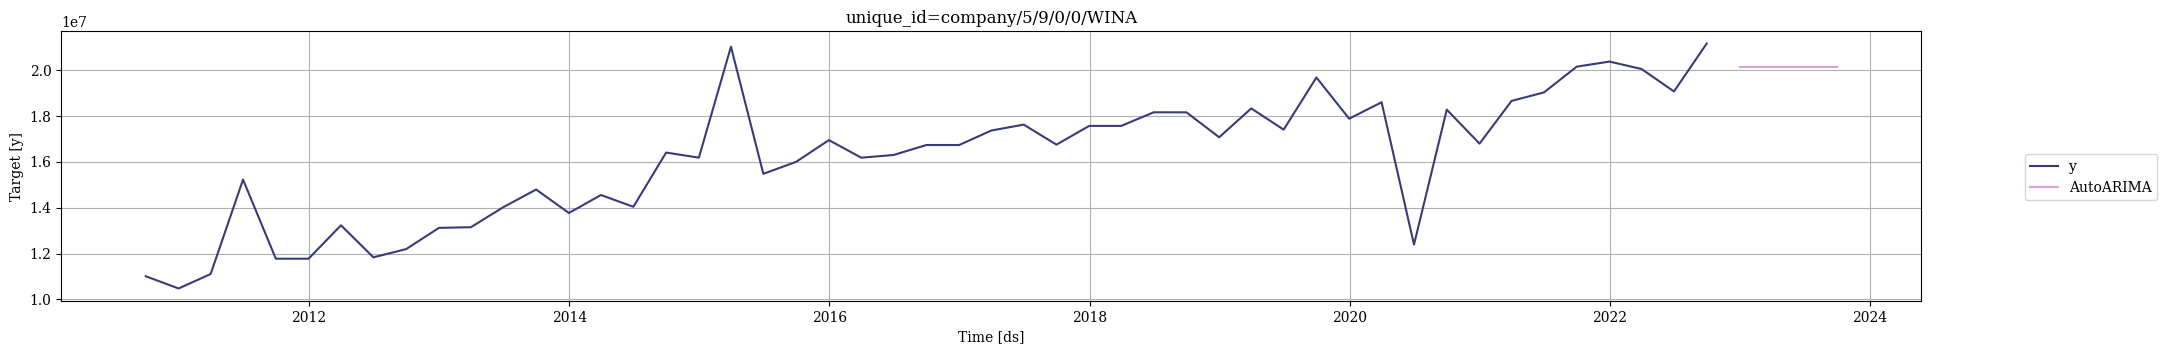

In [114]:
fcst.plot(
    Y_train_df,
    Y_hat_df,
    models=["AutoARIMA"],
    unique_ids=["company/5/9/0/0/WINA"],
)

## Hierarchical reconciliation

In [146]:
hrec = HierarchicalReconciliation([TopDown(method="forecast_proportions")])

In [147]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

In [148]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

In [149]:
hplot = HierarchicalPlot(S=S_df, tags=tags)

In [222]:
DataGrid(pd.DataFrame(
    (
        Y_rec_df.set_index("ds", append=True)["AutoARIMA"]
        - Y_test_df.set_index("ds", append=True)["y"]
    )
    / Y_rec_df.set_index("ds", append=True)["AutoARIMA"]
))

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

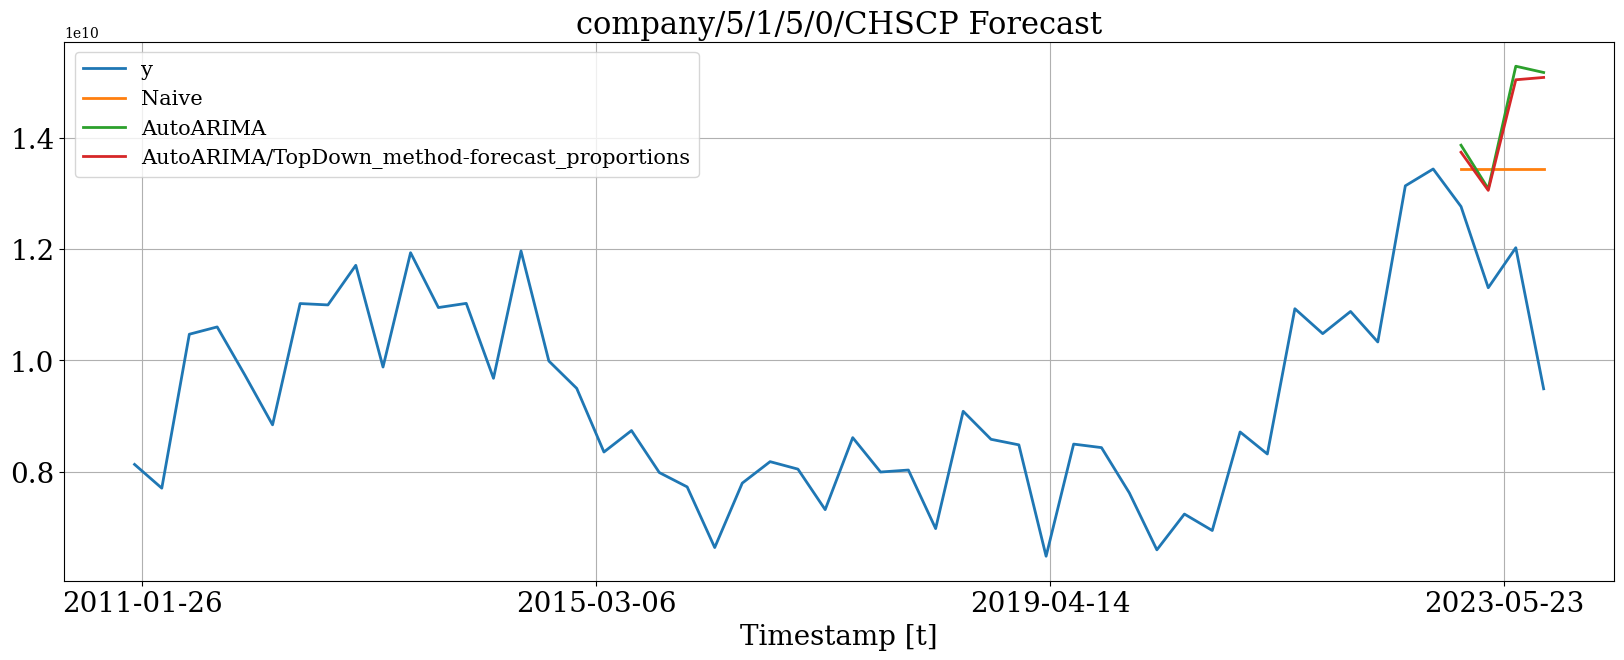

In [230]:
hplot.plot_series(
    series="company/5/1/5/0/CHSCP",
    Y_df=plot_df,
    models=["y", "Naive", "AutoARIMA", "AutoARIMA/TopDown_method-forecast_proportions"],
    level=[80],
)

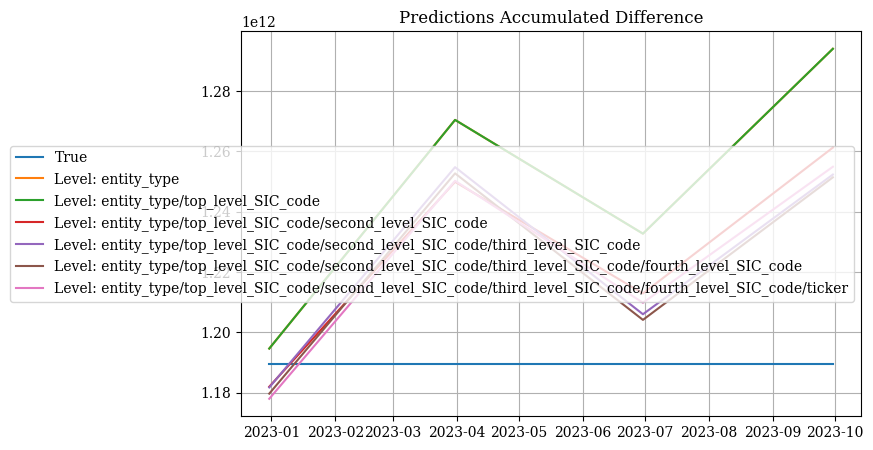

In [143]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [182]:
def mse(y, y_hat):
    return np.mean((y - y_hat) ** 2)


evaluator = HierarchicalEvaluation(evaluators=[mean_absolute_percentage_error])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    tags=tags,
    benchmark="Naive",
)

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [184]:
evaluation.T

level,Overall,entity_type,entity_type/top_level_SIC_code,entity_type/top_level_SIC_code/second_level_SIC_code,entity_type/top_level_SIC_code/second_level_SIC_code/third_level_SIC_code,entity_type/top_level_SIC_code/second_level_SIC_code/third_level_SIC_code/fourth_level_SIC_code,entity_type/top_level_SIC_code/second_level_SIC_code/third_level_SIC_code/fourth_level_SIC_code/ticker
metric,mean_absolute_percentage_error-scaled,mean_absolute_percentage_error-scaled,mean_absolute_percentage_error-scaled,mean_absolute_percentage_error-scaled,mean_absolute_percentage_error-scaled,mean_absolute_percentage_error-scaled,mean_absolute_percentage_error-scaled
AutoARIMA,0.987737,1.612961,1.612961,0.665622,0.898385,0.896933,0.999483
Naive,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AutoARIMA/TopDown_method-forecast_proportions,0.982811,1.612961,1.612961,0.841461,0.923181,0.91572,0.990387
Naive/TopDown_method-forecast_proportions,1.0,1.0,1.0,1.0,1.0,1.0,1.0
